In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
import logging
from tqdm import tqdm
import random
import h5py
from torch.utils.data import Dataset
from torchvision import transforms
from scipy import ndimage
from scipy.ndimage import zoom
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from torch.nn.modules.loss import CrossEntropyLoss
import torch.optim as optim

In [25]:
from models import UNet, UNETR
import utils

In [26]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TRAIN_DIR = './Synapse/train_npz/'
LIST_DIR = './lists_Synapse'

db_train = utils.Synapse_dataset(base_dir=TRAIN_DIR, list_dir=LIST_DIR, split="train",
                            transform=transforms.Compose(
                            [utils.RandomGenerator(output_size=[224, 224])]))

In [27]:
def plot_prediction_synapse(model_list, dataset, fig, idx=0, is_unetr=False):
    '''Plot a sample image, its ground truth and the prediction of the model'''
    sample = dataset[idx]
    sample_image, sample_mask = sample['image'], sample['label']
    sample_image_to_show = sample_image.permute(1, 2, 0)[:,:,0]
    fig.add_subplot(2, 3, 1)
    plt.title('Image')
    plt.imshow(sample_image_to_show, cmap = 'gray')
    plt.axis('off')

    fig.add_subplot(2, 3, 2)
    plt.title('Ground truth')
    plt.imshow(sample_mask)
    plt.axis('off')
    print('Ground truth :')
    used_classes = np.unique(sample_mask)
    s = 'Found classes :'
    for cls in used_classes:
        s += ' ' + str(cls)
    print(s)

    i = 3
    for m in model_list:
        fig.add_subplot(2, 3, i)
        plt.title(m)
        print('Model :', m)
        with torch.no_grad():
            to_pred = torch.from_numpy(np.array([sample_image.numpy()])).to(device=DEVICE)
            if is_unetr:
                to_pred = to_pred.expand(-1, 3, -1, -1)
            model = model_list[m]
            prediction = model(to_pred)
            plt.imshow(prediction.argmax(1).cpu().numpy()[0])
            plt.axis('off')
            used_classes = np.unique(prediction.argmax(1).cpu().numpy()[0])
            s = 'Found classes :'
            for cls in used_classes:
                s += ' ' + str(cls)
            print(s)
        i += 1

In [28]:
unetr_list = {}

unetr_list['UNETR_6'] = UNETR(depth=6, skip_connections=[2,5], pretrained_name='vit_base_patch16_224', num_classes=9).to(DEVICE)
unetr_list['UNETR_6'].load_state_dict(torch.load("saved_models/UNETR/UNETR_6.pth"))
unetr_list['UNETR_3'] = UNETR(depth=3, skip_connections=[2], pretrained_name='vit_base_patch16_224', num_classes=9).to(DEVICE)
unetr_list['UNETR_3'].load_state_dict(torch.load("saved_models/UNETR/UNETR_3.pth"))
unetr_list['UNETR_2'] = UNETR(depth=2, skip_connections=[1], pretrained_name='vit_base_patch16_224', num_classes=9).to(DEVICE)
unetr_list['UNETR_2'].load_state_dict(torch.load("saved_models/UNETR/UNETR_2.pth"))
unetr_list['UNETR_1'] = UNETR(depth=1, skip_connections=[0], pretrained_name='vit_base_patch16_224', num_classes=9).to(DEVICE)
unetr_list['UNETR_1'].load_state_dict(torch.load("saved_models/UNETR/UNETR_1.pth"))

<All keys matched successfully>

Ground truth :
Found classes : 0 1 5 7 8
Model : UNETR_6
Found classes : 0 1 5 7 8
Model : UNETR_3
Found classes : 0 1 4 5 7 8
Model : UNETR_2
Found classes : 0 1 5 7 8
Model : UNETR_1
Found classes : 0 1 5 7 8


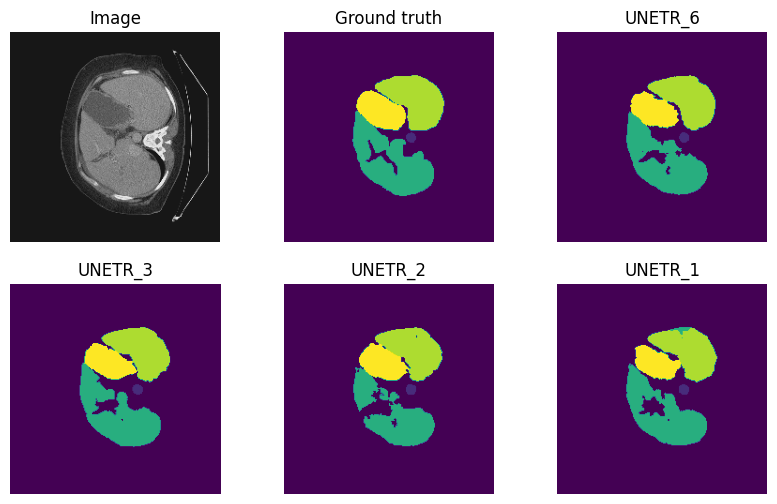

In [29]:
figure = plt.figure(figsize=(10, 6))
plot_prediction_synapse(unetr_list, db_train, figure, idx=360, is_unetr=True)

Ground truth :
Found classes : 0 1 5
Model : UNETR_6
Found classes : 0 1 5
Model : UNETR_3
Found classes : 0 1 5
Model : UNETR_2
Found classes : 0 1 5
Model : UNETR_1
Found classes : 0 1 5


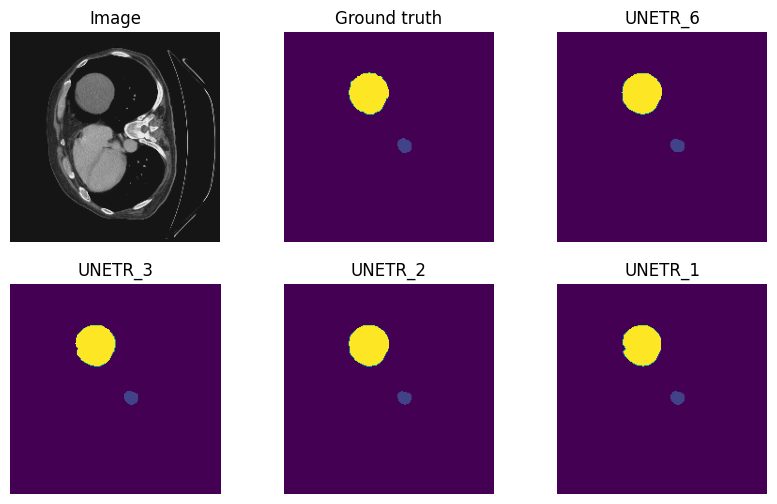

In [30]:
figure = plt.figure(figsize=(10, 6))
plot_prediction_synapse(unetr_list, db_train, figure, idx=500, is_unetr=True)

Ground truth :
Found classes : 0 1 2 3 4 5 6 7 8
Model : UNETR_6
Found classes : 0 1 3 4 5 6 7 8
Model : UNETR_3
Found classes : 0 1 2 3 4 5 6 7 8
Model : UNETR_2
Found classes : 0 1 3 4 5 6 7 8
Model : UNETR_1
Found classes : 0 1 3 4 5 6 7 8


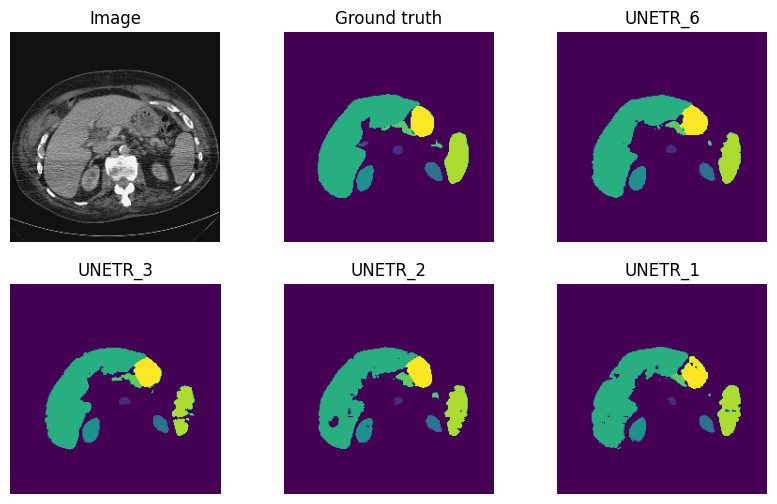

In [31]:
figure = plt.figure(figsize=(10, 6))
plot_prediction_synapse(unetr_list, db_train, figure, idx=200, is_unetr=True)

Ground truth :
Found classes : 0 1 2 5 7 8
Model : UNETR_6
Found classes : 0 1 5 7 8
Model : UNETR_3
Found classes : 0 1 2 5 7 8
Model : UNETR_2
Found classes : 0 1 2 3 5 7 8
Model : UNETR_1
Found classes : 0 1 5 7 8


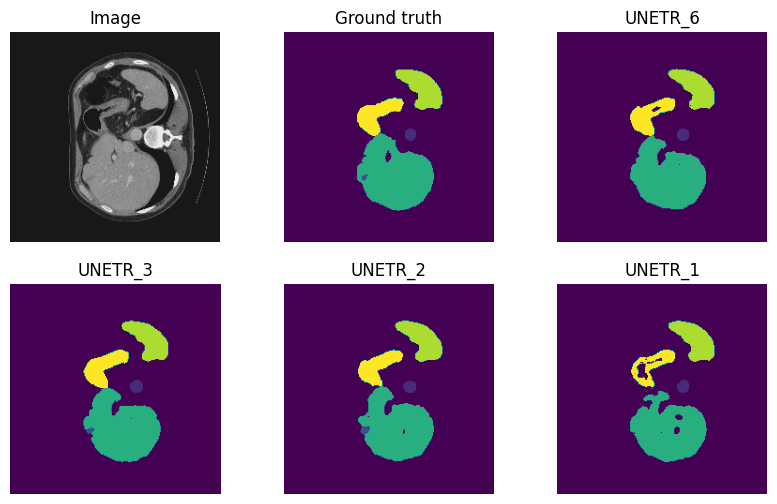

In [32]:
figure = plt.figure(figsize=(10, 6))
plot_prediction_synapse(unetr_list, db_train, figure, idx=60, is_unetr=True)

In [33]:
unet_list = {}

unet_list['UNet_1'] = UNet(depth=1, input_size=[1], num_classes=9, dilation=2).to(DEVICE)
unet_list['UNet_1'].load_state_dict(torch.load("saved_models/UNet/UNet_1_dilation2_epoch_50.pth"))
unet_list['UNet_2'] = UNet(depth=2, input_size=[1], num_classes=9, dilation=2).to(DEVICE)
unet_list['UNet_2'].load_state_dict(torch.load("saved_models/UNet/UNet_2_dilation2_epoch_50.pth"))
unet_list['UNet_3'] = UNet(depth=3, input_size=[1], num_classes=9, dilation=2).to(DEVICE)
unet_list['UNet_3'].load_state_dict(torch.load("saved_models/UNet/UNet_3_dilation2_epoch_50.pth"))
unet_list['UNet_4'] = UNet(depth=4, input_size=[1], num_classes=9, dilation=2).to(DEVICE)
unet_list['UNet_4'].load_state_dict(torch.load("saved_models/UNet/UNet_4_dilation2_epoch_50.pth"))

[1, 64, 128]
[1, 64, 128, 256]
[1, 64, 128, 256, 512]
[1, 64, 128, 256, 512, 1024]


<All keys matched successfully>

Ground truth :
Found classes : 0 1 5 7 8
Model : UNet_1
Found classes : 0 1 2 3 4 5 6 7 8
Model : UNet_2
Found classes : 0 1 4 5 6 7 8
Model : UNet_3
Found classes : 0 1 5 7 8
Model : UNet_4
Found classes : 0 1 5 7 8


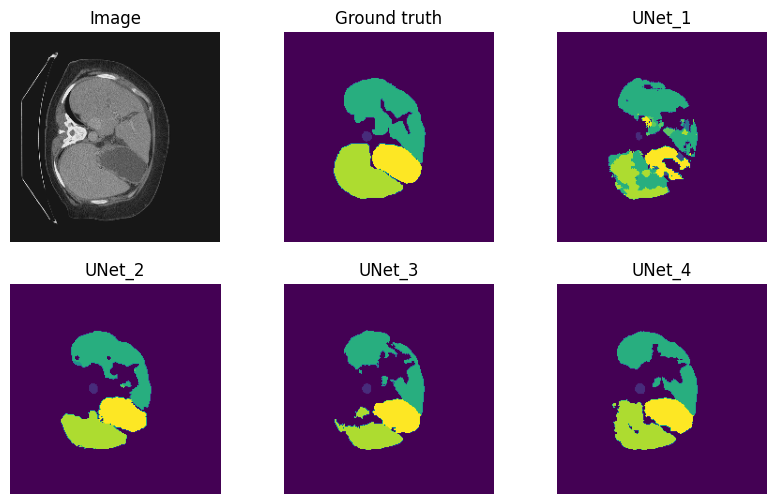

In [34]:
figure = plt.figure(figsize=(10, 6))
plot_prediction_synapse(unet_list, db_train, figure, idx=360)